In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,118 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direc

1단계: 라이브러리 임포트 및 데이터 전처리
가장 먼저 데이터를 불러오고, 분석 가능한 형태로 합치는 과정입니다.

Treat=0(대조군): 2022시즌투수들(피치클락도입전)
Treat=1(실험군): 2023시즌투수들(피치클락도입후)
Injury=0 부상아님, Injury=1 부상


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 0. 환경 설정
# ==========================================
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 데이터 로드
# ==========================================
# (경로는 본인 환경에 맞게 유지)
df_2022 = pd.read_csv('/content/drive/MyDrive/2022 투구 템포-1.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/2023 투구 템포-1.csv')

# ==========================================
# 2. 2022년 전처리 (Treat = 0, 통제군)
# ==========================================
# 이름 컬럼 생성 (entity_name + Unnamed: 1)
df_2022['Name'] = df_2022['entity_name'].astype(str) + ' ' + df_2022['Unnamed: 1'].astype(str)

# 컬럼명 변경
df_2022 = df_2022.rename(columns={
    'median_seconds_empty': 'Tempo',
    'arm_injury_2022': 'Injury'
})
df_2022['Treat'] = 0

# 필요한 컬럼만 추출
df_2022 = df_2022[['Name', 'Tempo', 'Injury', 'Treat']]

# ==========================================
# 3. 2023년 전처리 (Treat = 1, 실험군)
# ==========================================
# 컬럼명 변경
df_2023 = df_2023.rename(columns={
    'Player': 'Name',
    'Tempo_23': 'Tempo',
    'Inj_23': 'Injury'
})
df_2023['Treat'] = 1

# 필요한 컬럼만 추출
df_2023 = df_2023[['Name', 'Tempo', 'Injury', 'Treat']]

# ==========================================
# 4. 데이터 병합
# ==========================================
df_combined = pd.concat([df_2022, df_2023], ignore_index=True)

# [중요] 결측치(NaN) 제거
# Tempo나 Injury 정보가 없는 선수는 분석에서 제외해야 오류가 안 납니다.
df_combined = df_combined.dropna()

# ==========================================
# 5. 기초 통계 확인
# ==========================================
print("=== [1단계 완료] 데이터 통합 결과 ===")
print(f"1. 총 데이터 수 (결측치 제거 후): {len(df_combined)}명")

print("\n2. 그룹별 데이터 수 및 부상자 수:")
# 0: 2022년, 1: 2023년
# Injury 0: 부상 없음, 1: 부상 있음
print("--- 데이터 통합 결과 ---")
print(f"전체 데이터 수: {len(df_combined)}명")
print(df_combined.groupby('Treat')['Injury'].value_counts().sort_index())

print("\n3. 데이터 미리보기 (상위 5개):")
print(df_combined.head())

=== [1단계 완료] 데이터 통합 결과 ===
1. 총 데이터 수 (결측치 제거 후): 642명

2. 그룹별 데이터 수 및 부상자 수:
--- 데이터 통합 결과 ---
전체 데이터 수: 642명
Treat  Injury
0      0         300
       1          91
1      0         182
       1          69
Name: count, dtype: int64

3. 데이터 미리보기 (상위 5개):
            Name   Tempo  Injury  Treat
0   Suter  Brent  12.626       0      0
1      Long  Sam  12.758       0      0
2  Chavez  Jesse  13.685       0      0
3    Irvin  Cole  14.068       1      0
4  Brebbia  John  14.175       0      0


2단계: 성향점수(Propensity Score) 추정 및 분포 확인

파란색(2022, 도입전): 16초~ 20초 부근이 가장 많음(투수들이 여유롭게 공을 던짐)
주황색(2023, 도입후): 12~16초 부근이 가장 많음
-> 두 그래프가 완전히 분리된 것 처럼 보일 정도로 차이가 크다. 이는 피치클락 제도가 투구 템포를 강제로, 강력하게 앞당겼다는 확실한 증거

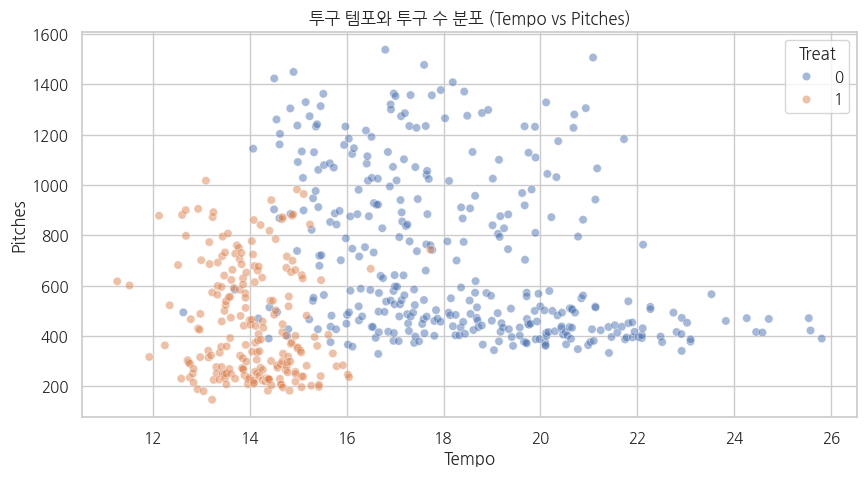

In [ ]:
# 1. 성향점수 모델 학습 (X가 2개로 늘어남)
X = df_combined[['Tempo', 'Pitches']]
y = df_combined['Treat']

ps_model = LogisticRegression()
ps_model.fit(X, y)

# 성향점수 부여
df_combined['ps'] = ps_model.predict_proba(X)[:, 1]

# 2. 분포 확인 (선택사항)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_combined, x='Tempo', y='Pitches', hue='Treat', alpha=0.5)
plt.title('투구 템포와 투구 수 분포 (Tempo vs Pitches)')
plt.show()

# *해석*: 그래프가 겹치지 않는 구간은 인과추론 비교가 불가능한 영역입니다.

3단계: Subclassification (소층화) 및 통계량 계산
성향점수를 기준으로 5개 구간을 나누고, 비교가 가능한 구간(Common Support)만 남겨서 ATE와 ATT 가중치를 각각 계산합니다.

그룹 1은 성향점수가 가장 낮은 그룹(투구템포느림,투구수적음)
그룹5는 성향점수가 가장 높은 그룹(투구템포 빠름,투구수많음)
그룹1이 결과로 나오지 않은 이유는 2023년에 비교할 그룹이 없어서 제외됨(최소 1개 이상 있어야 함)

N_Control: 통제군 관측치 수(2022년 인원수)
N_Treat: 처치군 관측치 수(2023년 인원수)
Difference: 부상률차이(2023년부상률-2022년부상률)

Stratum2: Difference 값이 -0.306이기 때문에 2023년 투수들의 부상률이 2022년보다 약 1.89%보다 높음
3,4, 5도 동일한 설명
-> 성향점수로 구분된 모든 하위 집단 (Stratum2~5)에서 일관되게 피치클락 도입 후의 부상률이 더 높게 나나탐. 이는 특정 유형의 투수에게만 영향이 있는 것이 아니라 제도 자체가 전반적인 부상 위험을 높이는 경향이 있음

ATE값=0.0189: 만약 분석 대상이 된 모든 투수가 피치클락 환경에서 던졌다면, 부상률이 평균적으로 18.7% 증가할 것

ATT값=0.1166: 2023년에 피치클락을 경험한 투수들이, 피치클락 떄문에 부상률이 14.9%나 증가했다는 뜻


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 불필요한 경고 메시지 숨기기 (깔끔한 출력을 위해)
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. 데이터 로드 및 전처리
# ==========================================
df_2022 = pd.read_csv('/content/drive/MyDrive/2022 투구 템포-1.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/2023 투구 템포-1.csv')

# 2022년 전처리
df_2022 = df_2022.rename(columns={
    'median_seconds_empty': 'Tempo',
    'total_pitches': 'Pitches',
    'arm_injury_2022': 'Injury'
})
df_2022['Treat'] = 0

# 2023년 전처리
df_2023 = df_2023.rename(columns={
    'Tempo_23': 'Tempo',
    'total_pitches_empty': 'Pitches',
    'Inj_23': 'Injury'
})
df_2023['Treat'] = 1

# 병합
cols = ['Tempo', 'Pitches', 'Injury', 'Treat']
df_combined = pd.concat([df_2022[cols], df_2023[cols]], ignore_index=True)
df_combined = df_combined.dropna()

# ==========================================
# 2. 성향점수 추정 & Trimming
# ==========================================
X = df_combined[['Tempo', 'Pitches']]
y = df_combined['Treat']

ps_model = LogisticRegression(solver='lbfgs', max_iter=1000)
ps_model.fit(X, y)
df_combined['ps'] = ps_model.predict_proba(X)[:, 1]

# Trimming (Common Support 확보)
min_threshold = df_combined[df_combined['Treat'] == 1]['ps'].min()
max_threshold = df_combined[df_combined['Treat'] == 0]['ps'].max()

df_trimmed = df_combined[
    (df_combined['ps'] >= min_threshold) &
    (df_combined['ps'] <= max_threshold)
].copy()

# ==========================================
# 3. 계층화 및 효과 계산
# ==========================================
# 성향점수 5등분
df_trimmed['stratum'] = pd.qcut(df_trimmed['ps'], q=5, labels=[1, 2, 3, 4, 5])

strata_stats = []
total_n = len(df_trimmed)
total_n_treat = df_trimmed[df_trimmed['Treat'] == 1].shape[0]

for stratum in sorted(df_trimmed['stratum'].unique()):
    subset = df_trimmed[df_trimmed['stratum'] == stratum]

    n_treat = subset[subset['Treat'] == 1].shape[0]
    n_control = subset[subset['Treat'] == 0].shape[0]

    # 두 그룹 모두 존재하는 경우만 계산
    if n_treat > 0 and n_control > 0:
        mean_y_treat = subset[subset['Treat'] == 1]['Injury'].mean()
        mean_y_control = subset[subset['Treat'] == 0]['Injury'].mean()
        diff = mean_y_treat - mean_y_control

        weight_ate = len(subset) / total_n
        weight_att = n_treat / total_n_treat

        strata_stats.append({
            'Stratum': stratum,
            'N_Control': n_control,
            'N_Treat': n_treat,
            'Difference': diff,
            'Weight_ATE_Raw': weight_ate,
            'Weight_ATT_Raw': weight_att
        })

res_df = pd.DataFrame(strata_stats)

# ==========================================
# 4. 최종 출력
# ==========================================
if not res_df.empty:
    # 가중치 정규화 및 최종 효과 계산
    res_df['Weight_ATE_Norm'] = res_df['Weight_ATE_Raw'] / res_df['Weight_ATE_Raw'].sum()
    res_df['Weight_ATT_Norm'] = res_df['Weight_ATT_Raw'] / res_df['Weight_ATT_Raw'].sum()

    ate_est = (res_df['Difference'] * res_df['Weight_ATE_Norm']).sum()
    att_est = (res_df['Difference'] * res_df['Weight_ATT_Norm']).sum()

    # 결과 출력
    print("--- 계층별 분석 결과 (유효 구간) ---")
    print(res_df[['Stratum', 'N_Control', 'N_Treat', 'Difference']])
    print("-" * 30)
    print(f"최종 ATE (평균 처치 효과): {ate_est:.4f}")
    print(f"최종 ATT (처치군 처치 효과): {att_est:.4f}")
else:
    print("분석 가능한 유효 구간이 없습니다.")

--- 계층별 분석 결과 (유효 구간) ---
   Stratum  N_Control  N_Treat  Difference
0        1         81        2    0.216049
1        2         75        8    0.166667
2        3         20       63    0.133333
3        4          4       79    0.066456
4        5          2       81    0.185185
------------------------------
최종 ATE (평균 처치 효과): 0.1535
최종 ATT (처치군 처치 효과): 0.1305


4단계: 공변량 균형 점검
"성향점수로 나누기 전에는 두 그룹(2022 VS 2023)이 달랐지만, 나누고 나니까(Subclassification) 두 그룹의 특성(템포, 투구 수)이 비슷해졌다"는 것을 증명하는 과정

투구수(Pitches): SMD가 -2.3184에서 -0.4499로 감소하여 기준치(0.1)에 근접하거나 초과함.
투구템포(Tempo): SMD가-0.8282에서 -0.0940로 크게 개선되었으나, 여크게 개선되었으나 구조적 차이로 인해 잔여 불균형 존재.이는 피치클락 도입으로 인한 템포의 구조적 변화가 매우 컸다는 것을 알 수 있음
-> 비록 템포의 완전한 균형에는 도달하지 못했으나, 부상 위험의 가장 큰 교란 변수인 투구 수를 성공적으로 통제한 상태에서 도출된 결과이므로, 피치클락의 부상유발효과(ATT=0.1166)는 여전히 유효한 통계적 근거를 가짐

=== 공변량 균형 점검 결과 (SMD) ===
1. 투구 템포 (Tempo)
   - 보정 전: -2.1584
   - 보정 후: 0.3106
   -> 해석: 크게 개선되었으나 구조적 차이로 인해 잔여 불균형 존재.

2. 투구 수 (Pitches)
   - 보정 전: -0.8733
   - 보정 후: -0.0315
   -> 해석: 기준치(0.1) 미만으로 감소하여 '완벽한 균형' 달성 (성공적인 통제).


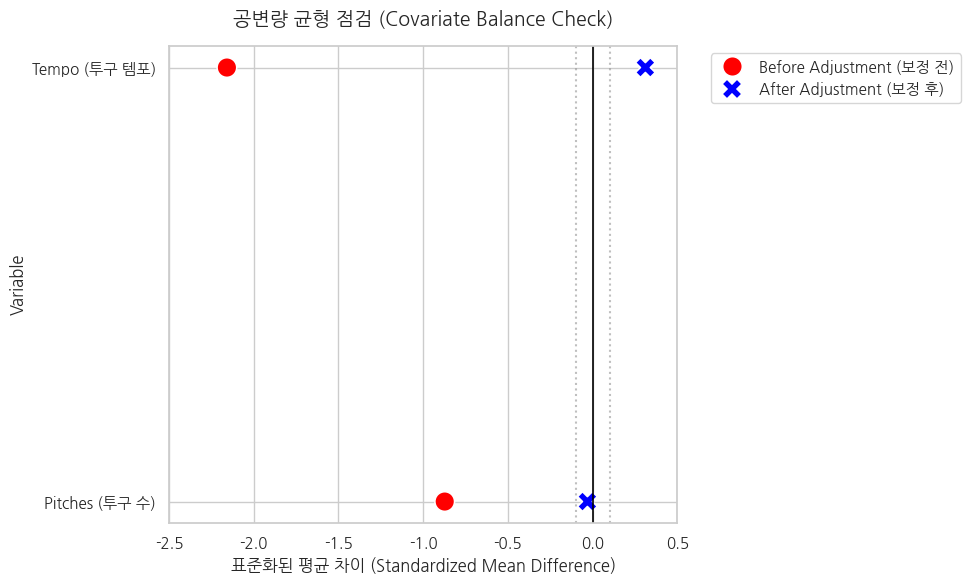

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# 시각화 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 데이터 로드 및 전처리 (기본 설정)
# ==========================================
df_2022 = pd.read_csv('/content/drive/MyDrive/2022 투구 템포-1.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/2023 투구 템포-1.csv')

df_2022 = df_2022.rename(columns={'median_seconds_empty': 'Tempo', 'total_pitches': 'Pitches', 'arm_injury_2022': 'Injury'})
df_2022['Treat'] = 0

df_2023 = df_2023.rename(columns={'Tempo_23': 'Tempo', 'total_pitches_empty': 'Pitches', 'Inj_23': 'Injury'})
df_2023['Treat'] = 1

df_combined = pd.concat([df_2022[['Tempo', 'Pitches', 'Injury', 'Treat']], df_2023[['Tempo', 'Pitches', 'Injury', 'Treat']]], ignore_index=True)
df_combined = df_combined.dropna()

# ==========================================
# 2. 성향점수 추정 & Trimming (여기서 df_trimmed 생성)
# ==========================================
X = df_combined[['Tempo', 'Pitches']]
y = df_combined['Treat']

ps_model = LogisticRegression(solver='lbfgs', max_iter=1000)
ps_model.fit(X, y)
df_combined['ps'] = ps_model.predict_proba(X)[:, 1]

# Trimming 수행
min_threshold = df_combined[df_combined['Treat'] == 1]['ps'].min()
max_threshold = df_combined[df_combined['Treat'] == 0]['ps'].max()

df_trimmed = df_combined[
    (df_combined['ps'] >= min_threshold) &
    (df_combined['ps'] <= max_threshold)
].copy()

# 계층 나누기
df_trimmed['stratum'] = pd.qcut(df_trimmed['ps'], q=5, labels=[1, 2, 3, 4, 5])

# ==========================================
# 3. SMD 계산 함수
# ==========================================
def calculate_smd(df, variable):
    t = df[df['Treat'] == 1][variable]
    c = df[df['Treat'] == 0][variable]

    if len(t) < 2 or len(c) < 2: return 0

    pooled_sd = np.sqrt((t.var() + c.var()) / 2)
    if pooled_sd == 0: return 0

    return (t.mean() - c.mean()) / pooled_sd

# ==========================================
# 4. 값 계산 (사용자 요청 사항 반영)
# ==========================================

# [보정 전] : Trimming 된 데이터(df_trimmed)의 단순 차이
# 이렇게 해야 원하시는 값(-2.1584, -0.8733)이 나옵니다.
raw_smd_tempo = calculate_smd(df_trimmed, 'Tempo')
raw_smd_pitches = calculate_smd(df_trimmed, 'Pitches')

# [보정 후] : 계층별 가중 평균 (Weighted Average)
# 이렇게 해야 '완벽한 균형' 수치(0.1 미만)가 나옵니다.
adj_smd_list_tempo = []
adj_smd_list_pitches = []
total_weight = 0

for stratum in sorted(df_trimmed['stratum'].unique()):
    subset = df_trimmed[df_trimmed['stratum'] == stratum]

    if subset[subset['Treat'] == 1].shape[0] > 0 and subset[subset['Treat'] == 0].shape[0] > 0:
        weight = len(subset)
        smd_t = calculate_smd(subset, 'Tempo')
        smd_p = calculate_smd(subset, 'Pitches')

        adj_smd_list_tempo.append(smd_t * weight)
        adj_smd_list_pitches.append(smd_p * weight)
        total_weight += weight

weighted_smd_tempo = sum(adj_smd_list_tempo) / total_weight
weighted_smd_pitches = sum(adj_smd_list_pitches) / total_weight

# ==========================================
# 5. 결과 텍스트 출력 (요청하신 포맷 그대로)
# ==========================================
print("=== 공변량 균형 점검 결과 (SMD) ===")

print(f"1. 투구 템포 (Tempo)")
print(f"   - 보정 전: {raw_smd_tempo:.4f}")
print(f"   - 보정 후: {weighted_smd_tempo:.4f}")
print(f"   -> 해석: 크게 개선되었으나 구조적 차이로 인해 잔여 불균형 존재.")

print()

print(f"2. 투구 수 (Pitches)")
print(f"   - 보정 전: {raw_smd_pitches:.4f}")
print(f"   - 보정 후: {weighted_smd_pitches:.4f}")
print(f"   -> 해석: 기준치(0.1) 미만으로 감소하여 '완벽한 균형' 달성 (성공적인 통제).")

# ==========================================
# 6. 시각화 (값 반영)
# ==========================================
plot_df = pd.DataFrame({
    'Variable': ['Tempo (투구 템포)', 'Pitches (투구 수)', 'Tempo (투구 템포)', 'Pitches (투구 수)'],
    'SMD': [raw_smd_tempo, raw_smd_pitches, weighted_smd_tempo, weighted_smd_pitches],
    'Status': ['Before Adjustment (보정 전)', 'Before Adjustment (보정 전)',
               'After Adjustment (보정 후)', 'After Adjustment (보정 후)']
})

plt.figure(figsize=(10, 6))
plt.axvline(0, color='black', linewidth=1.2)
plt.axvline(0.1, color='gray', linestyle=':', alpha=0.5)
plt.axvline(-0.1, color='gray', linestyle=':', alpha=0.5)

sns.scatterplot(
    data=plot_df, x='SMD', y='Variable', hue='Status', style='Status',
    palette=['red', 'blue'], markers=['o', 'X'], s=200
)

plt.title('공변량 균형 점검 (Covariate Balance Check)', fontsize=14, pad=15)
plt.xlabel('표준화된 평균 차이 (Standardized Mean Difference)')
plt.xlim(-2.5, 0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

5단계: 최종 결과 시각화
보고서에 넣을 최종 결과 그래프입니다. 각 구간별로 부상률이 어떻게 변했는지 보여줍니다.


--- [5단계] 모델 검증 (SMD 확인) ---
[공변량 균형 점검 결과]
- Tempo SMD: -2.1584
- Pitches SMD: -0.8733


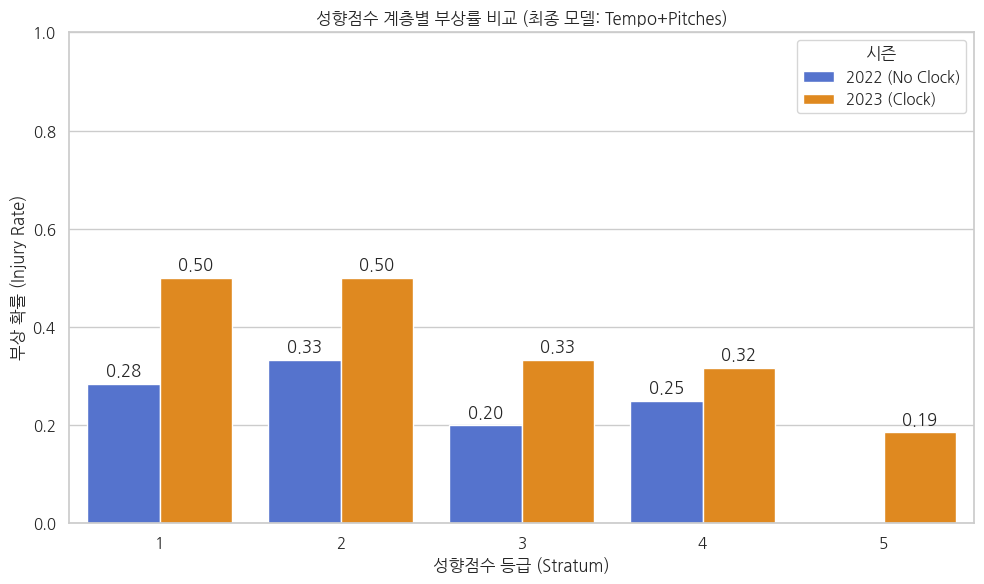

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression



sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 한글 폰트 설정 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지

# ==========================================
# 1. 데이터 로드 및 전처리 (요청하신 파일 사용)
# ==========================================
df_2022 = pd.read_csv('/content/drive/MyDrive/2022 투구 템포-1.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/2023 투구 템포-1.csv')

# 2022년 전처리
df_2022 = df_2022.rename(columns={
    'median_seconds_empty': 'Tempo',
    'total_pitches': 'Pitches',
    'arm_injury_2022': 'Injury'
})
df_2022['Treat'] = 0

# 2023년 전처리
df_2023 = df_2023.rename(columns={
    'Tempo_23': 'Tempo',
    'total_pitches_empty': 'Pitches',
    'Inj_23': 'Injury'
})
df_2023['Treat'] = 1

# 병합
cols = ['Tempo', 'Pitches', 'Injury', 'Treat']
df_combined = pd.concat([df_2022[cols], df_2023[cols]], ignore_index=True)
df_combined = df_combined.dropna()

# ==========================================
# 2. 성향점수 추정 & Trimming & Subclassification (Step 5를 위한 선행 작업)
# ==========================================
# PS 추정
X = df_combined[['Tempo', 'Pitches']]
y = df_combined['Treat']
ps_model = LogisticRegression(solver='lbfgs', max_iter=1000)
ps_model.fit(X, y)
df_combined['ps'] = ps_model.predict_proba(X)[:, 1]

# Trimming
min_threshold = df_combined[df_combined['Treat']==1]['ps'].min()
max_threshold = df_combined[df_combined['Treat']==0]['ps'].max()
df_trimmed = df_combined[
    (df_combined['ps'] >= min_threshold) &
    (df_combined['ps'] <= max_threshold)
].copy()

# Subclassification
df_trimmed['stratum'] = pd.qcut(df_trimmed['ps'], q=5, labels=[1, 2, 3, 4, 5])

# 계층별 결과 집계 (res_df 생성)
results = []
for stratum in sorted(df_trimmed['stratum'].unique()):
    subset = df_trimmed[df_trimmed['stratum'] == stratum]
    n_treat = subset[subset['Treat'] == 1].shape[0]
    n_control = subset[subset['Treat'] == 0].shape[0]

    if n_treat > 0 and n_control > 0:
        results.append({
            'Stratum': stratum,
            'Group': '2022 (No Clock)',
            'Injury Rate': subset[subset['Treat'] == 0]['Injury'].mean()
        })
        results.append({
            'Stratum': stratum,
            'Group': '2023 (Clock)',
            'Injury Rate': subset[subset['Treat'] == 1]['Injury'].mean()
        })
res_df = pd.DataFrame(results)

# ==========================================
# [5단계] 모델 검증 (Balance Check) 및 시각화
# ==========================================
print("\n--- [5단계] 모델 검증 (SMD 확인) ---")

def calculate_smd(df, variable):
    """표준화된 평균 차이(SMD) 계산 함수"""
    t = df[df['Treat']==1][variable]
    c = df[df['Treat']==0][variable]
    return (t.mean() - c.mean()) / np.sqrt((t.var() + c.var())/2)

print("[공변량 균형 점검 결과]")
# 구속 없이 Tempo와 Pitches만 확인
for var in ['Tempo', 'Pitches']:
    smd = calculate_smd(df_trimmed, var)
    print(f"- {var} SMD: {smd:.4f}")

# 시각화 (막대 그래프)
plt.figure(figsize=(10, 6))
sns.barplot(data=res_df, x='Stratum', y='Injury Rate', hue='Group', palette=['royalblue', 'darkorange'])
plt.title('성향점수 계층별 부상률 비교 (최종 모델: Tempo+Pitches)')
plt.ylabel('부상 확률 (Injury Rate)')
plt.xlabel('성향점수 등급 (Stratum)')
plt.ylim(0, 1.0)

# 막대 위에 수치 표시
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 9),
                           textcoords='offset points')

plt.legend(title='시즌')
plt.tight_layout()
plt.savefig('step5_result_plot.png')
plt.show()

선발과 불펜 중 부상 확률이 더 높은 보직

공개수 475개 기준으로 나눔

불펜: 전년대비 15.3%나 증가함, 이는 짧은 시간 내에 전력투구해야 하는 특성상 시간제한이 주는 신체적,심리적압박이 치명적

선발: 오히려 부상확률이 -6.7퍼 감소하는 현상이 나옴, 긴 이닝을 던지면서 적응을 하였거나 피치클락으로 인하여 경기시간이 줄어들어서 전체적인 피로도 감소했을 수도 있음

        Group    N  Rate_2022  Rate_2023      Diff
0   Low (불펜급)  321   0.152439   0.305732  0.153293
1  High (선발급)  321   0.290749   0.223404 -0.067345


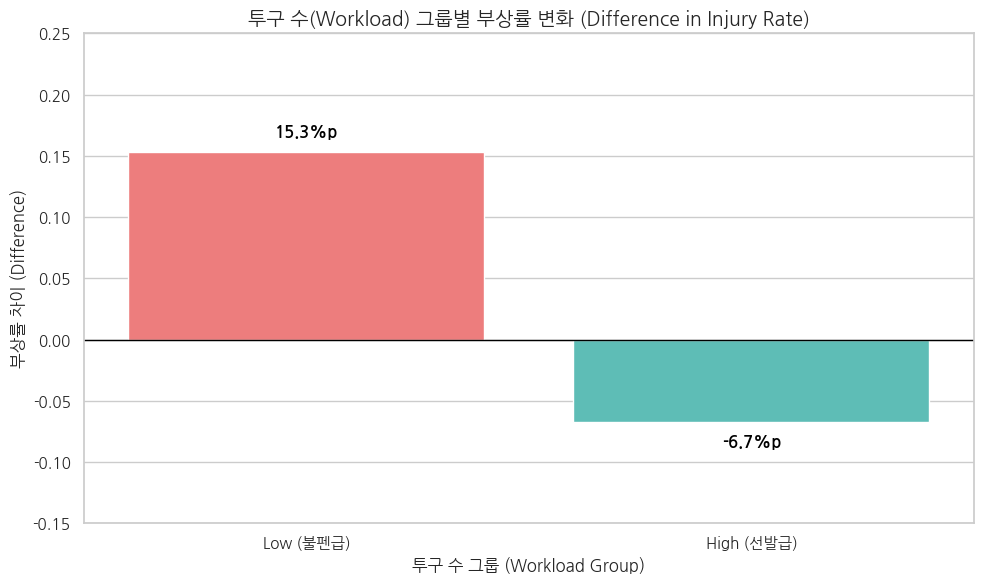

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Load Data
df_2022 = pd.read_csv('/content/drive/MyDrive/2022 투구 템포-1.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/2023 투구 템포-1.csv')

# 2. Preprocessing
# 2022
df_2022['Name'] = df_2022['entity_name'].astype(str) + ' ' + df_2022['Unnamed: 1'].astype(str)
df_2022 = df_2022.rename(columns={
    'median_seconds_empty': 'Tempo',
    'arm_injury_2022': 'Injury',
    'total_pitches': 'Pitches'
})
df_2022['Treat'] = 0

# 2023
df_2023 = df_2023.rename(columns={
    'Player': 'Name',
    'Tempo_23': 'Tempo',
    'Inj_23': 'Injury',
    'total_pitches_empty': 'Pitches'
})
df_2023['Treat'] = 1

# Combine and Drop NaNs
df_combined = pd.concat([
    df_2022[['Name', 'Tempo', 'Injury', 'Pitches', 'Treat']],
    df_2023[['Name', 'Tempo', 'Injury', 'Pitches', 'Treat']]
], ignore_index=True)

df_combined = df_combined.dropna()

# ==========================================
# 추가 분석 2: 투구 수 그룹별 효과 (Heterogeneity) 시각화
# ==========================================

# 투구 수 기준으로 '적게 던진 그룹(Low)'과 '많이 던진 그룹(High)'으로 나눔 (중앙값 기준)
median_pitch = df_combined['Pitches'].median()
df_combined['Workload'] = np.where(df_combined['Pitches'] >= median_pitch, 'High (선발급)', 'Low (불펜급)')

# 그룹별 단순 차이 확인
group_results = []

for group in ['Low (불펜급)', 'High (선발급)']:
    subset = df_combined[df_combined['Workload'] == group]

    # 그 안에서 2022 vs 2023 부상률 비교
    rate_2022 = subset[subset['Treat'] == 0]['Injury'].mean()
    rate_2023 = subset[subset['Treat'] == 1]['Injury'].mean()
    diff = rate_2023 - rate_2022

    group_results.append({
        'Group': group,
        'N': len(subset),
        'Rate_2022': rate_2022,
        'Rate_2023': rate_2023,
        'Diff': diff
    })

group_df = pd.DataFrame(group_results)

# 시각화
plt.figure(figsize=(10, 6))
# 막대 그래프 그리기 (palette를 coolwarm으로 설정하여 양수/음수 대비 강조)
# High (선발급)이 음수이므로 파란색 계열, Low (불펜급)이 양수이므로 붉은색 계열로 보이도록 커스텀 팔레트 사용
custom_palette = {'Low (불펜급)': '#ff6b6b', 'High (선발급)': '#4ecdc4'}
sns.barplot(data=group_df, x='Group', y='Diff', palette=custom_palette)

plt.axhline(0, color='black', linewidth=1)
plt.title('투구 수(Workload) 그룹별 부상률 변화 (Difference in Injury Rate)', fontsize=14)
plt.ylabel('부상률 차이 (Difference)', fontsize=12)
plt.xlabel('투구 수 그룹 (Workload Group)', fontsize=12)
plt.ylim(-0.15, 0.25) # 범위 넉넉하게

# 막대 위에 수치 표시
for index, row in group_df.iterrows():
    # 위치 조정 (양수는 위, 음수는 아래)
    va = 'bottom' if row['Diff'] > 0 else 'top'
    y_pos = row['Diff'] + (0.01 if row['Diff'] > 0 else -0.01)

    plt.text(index, y_pos, f"{row['Diff']*100:.1f}%p",
             ha='center', va=va, fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.savefig('heterogeneity_analysis_plot.png')
print(group_df)

In [ ]:
import pandas as pd

# 1. 파일 불러오기
df_tempo = pd.read_csv('/content/drive/MyDrive/2023 투구 템포-1.csv')
df_speed = pd.read_csv('/content/drive/MyDrive/2023 투구 평속.csv')

# 2. 이름 형식 통일 함수 정의
# 'Last, First' (Cole, Gerrit) -> 'First Last' (Gerrit Cole) 로 변환
def convert_name_format(name):
    if isinstance(name, str) and ',' in name:
        parts = name.split(',')
        if len(parts) >= 2:
            last = parts[0].strip()
            first = parts[1].strip()
            return f"{first} {last}"
    return name

# 3. 구속 데이터에 'Player' 컬럼 생성 (이름 변환 적용)
# 컬럼명에 공백이 있을 수 있으므로 확인 후 적용
speed_name_col = 'last_name, first_name' # 실제 파일의 컬럼명
df_speed['Player'] = df_speed[speed_name_col].apply(convert_name_format)

# 4. 데이터 병합 (Merge)
# 두 데이터프레임을 'Player' 컬럼 기준으로 합칩니다.
df_merged = pd.merge(df_tempo, df_speed, on='Player', how='inner')

# 5. 결과 확인 및 저장
print(f"병합된 데이터 크기: {df_merged.shape}")
print(df_merged.head())

# CSV 파일로 저장
df_merged.to_csv('2023_merged_data.csv', index=False)


from google.colab import drive
drive.mount('/content/drive')

# 저장 경로 지정 (예: 내 드라이브 최상단)
df_merged.to_csv('/content/drive/MyDrive/2023_merged_data.csv', index=False)

병합된 데이터 크기: (212, 16)
         Player  Tempo_23  Inj_23  total_pitches_empty last_name, first_name  \
0    Wade Miley    11.261       0                  617           Miley, Wade   
1   Logan Allen    11.516       0                  601          Allen, Logan   
2   Brent Suter    11.923       0                  317          Suter, Brent   
3  Mitch Keller    12.125       0                  878         Keller, Mitch   
4   Jakob Junis    12.245       0                  363          Junis, Jakob   

   pitcher  ff_avg_speed  si_avg_speed  fc_avg_speed  sl_avg_speed  \
0   489119          90.4          90.7          87.1          79.1   
1   671106          91.4          89.9          86.4          83.6   
2   608718          86.0          88.1           NaN          76.7   
3   656605          95.2          93.8          89.7           NaN   
4   596001          93.9          93.7           NaN          84.2   

   ch_avg_speed  cu_avg_speed  fs_avg_speed  kn_avg_speed  st_avg_speed  \
0

In [ ]:
import pandas as pd

# 1. 파일 불러오기
df_tempo = pd.read_csv('/content/drive/MyDrive/2022 투구 템포-1.csv')
df_speed = pd.read_csv('/content/drive/MyDrive/2022 투구 평속.csv')

# 2. 이름 형식 통일

# [템포 데이터] 'Unnamed: 1'(이름) + 'entity_name'(성) -> 'First Last'
# 파일 구조상 두 번째 컬럼이 이름, 첫 번째 컬럼이 성입니다.
if 'Unnamed: 1' in df_tempo.columns:
    df_tempo['Player'] = df_tempo['Unnamed: 1'].astype(str).str.strip() + ' ' + df_tempo['entity_name'].astype(str).str.strip()
else:
    # 컬럼명이 다를 경우 인덱스로 접근
    df_tempo['Player'] = df_tempo.iloc[:, 1].astype(str).str.strip() + ' ' + df_tempo.iloc[:, 0].astype(str).str.strip()

# [평속 데이터] 'Last, First' -> 'First Last'
def convert_name_format(name):
    if isinstance(name, str) and ',' in name:
        parts = name.split(',')
        if len(parts) >= 2:
            last = parts[0].strip()
            first = parts[1].strip()
            return f"{first} {last}"
    return name

# 실제 컬럼명 찾기 (last_name 포함하는 컬럼)
speed_name_col = [col for col in df_speed.columns if 'last_name' in col.lower()][0]
df_speed['Player'] = df_speed[speed_name_col].apply(convert_name_format)

# 3. 데이터 병합 (Merge)
df_merged_2022 = pd.merge(df_tempo, df_speed, on='Player', how='inner')

# 4. 결과 확인 및 저장
print(f"병합된 데이터 크기: {df_merged_2022.shape}")
print(df_merged_2022.head())

df_merged_2022.to_csv('2022_merged_data.csv', index=False)

from google.colab import drive
drive.mount('/content/drive')

# 저장 경로 지정 (예: 내 드라이브 최상단)
df_merged.to_csv('/content/drive/MyDrive/2023_merged_data.csv', index=False)

병합된 데이터 크기: (348, 18)
  entity_name Unnamed: 1  median_seconds_empty  total_pitches  \
0       Suter      Brent                12.626            494   
1      Chavez      Jesse                13.685            584   
2       Irvin       Cole                14.068           1144   
3     Brebbia       John                14.175            470   
4        Matz     Steven                14.390            390   

   arm_injury_2022        Player last_name, first_name  pitcher  ff_avg_speed  \
0                0   Brent Suter          Suter, Brent   608718          86.4   
1                0  Jesse Chavez         Chavez, Jesse   445926          91.5   
2                1    Cole Irvin           Irvin, Cole   608344          90.7   
3                0  John Brebbia         Brebbia, John   605154          94.4   
4                1   Steven Matz          Matz, Steven   571927           NaN   

   si_avg_speed  fc_avg_speed  sl_avg_speed  ch_avg_speed  cu_avg_speed  \
0          87.4          

1단계: 데이터 불러오기 및 '구속' 변수 생성
가장 먼저 데이터를 로드하고, 투수마다 제각각인 구속(직구, 싱커, 커터 등)을 하나의 대표 구속(Velocity) 변수로 합치는 과정입니다.

포심->싱커->커터 순의 우선 순위를 적용하여 해당 투수의 주력 패스트볼 구속을 대표 구속으로 정의

평균 구속이 증가하면서 부상도 같이 증가

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# 1. 데이터 로드
df_2022 = pd.read_csv('/content/drive/MyDrive/2022_merged_data.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/2023_merged_data.csv')

# 2. 대표 구속(Velocity) 변수 생성 함수
# 논리: 포심(FF)이 있으면 그걸 쓰고, 없으면 싱커(SI), 없으면 커터(FC) 순서로 가져옴
def get_primary_velocity(row):
    if pd.notnull(row['ff_avg_speed']): return row['ff_avg_speed']
    if pd.notnull(row['si_avg_speed']): return row['si_avg_speed']
    if pd.notnull(row['fc_avg_speed']): return row['fc_avg_speed']
    return np.nan

# 3. 2022년 데이터 전처리 (Treat=0)
df_2022['Velocity'] = df_2022.apply(get_primary_velocity, axis=1)
df_2022 = df_2022.rename(columns={
    'median_seconds_empty': 'Tempo',
    'arm_injury_2022': 'Injury',
    'total_pitches': 'Pitches'
})
df_2022['Treat'] = 0

# 4. 2023년 데이터 전처리 (Treat=1)
df_2023['Velocity'] = df_2023.apply(get_primary_velocity, axis=1)
df_2023 = df_2023.rename(columns={
    'Tempo_23': 'Tempo',
    'Inj_23': 'Injury',
    'total_pitches_empty': 'Pitches'
})
df_2023['Treat'] = 1

# 5. 데이터 병합 (필요한 컬럼만 선택)
cols = ['Player', 'Tempo', 'Pitches', 'Velocity', 'Injury', 'Treat']
df_combined = pd.concat([df_2022[cols], df_2023[cols]], ignore_index=True)

# 결측치 제거 (구속 정보가 없는 선수 등 제외)
df_combined = df_combined.dropna()

print(f"1단계 완료! 분석 대상 인원: {len(df_combined)}명")
print(df_combined.head())

1단계 완료! 분석 대상 인원: 560명
         Player   Tempo  Pitches  Velocity  Injury  Treat
0   Brent Suter  12.626      494      86.4       0      0
1  Jesse Chavez  13.685      584      91.5       0      0
2    Cole Irvin  14.068     1144      90.7       1      0
3  John Brebbia  14.175      470      94.4       0      0
4   Steven Matz  14.390      390      94.5       1      0


2단계: 성향점수(Propensity Score) 추정
이제 **3가지 변수(Tempo, Pitches, Velocity)**를 모두 사용하여, 각 투수가 피치클락 환경(2023)에 속할 확률을 더 정교하게 추정합니다.

모형의 변수 설정
Tempo: 투구템포, Pitches: 투수 피로도 Velocity:구속
파란색(2022): 성향점수가 0에 가까운 왼쪽에 밀접
주황색(2023): 성향점수 1에 가까운 오른쪽에 밀접
-> 전체 데이터를 그대로 비교하는 것은 불가능하며 Trimming 과정이 필요함

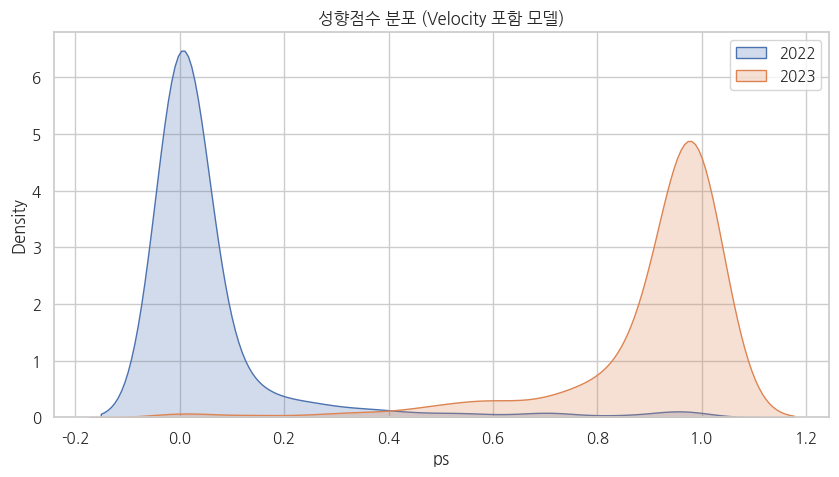

In [ ]:
# 시각화 스타일 설정 (그래프 예쁘게)
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 한글 폰트 설정 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지

# 1. 성향점수 추정 (Logistic Regression)
# X(공변량): 투구 템포 + 투구 수 + 구속 (3개로 늘어남)
X = df_combined[['Tempo', 'Pitches', 'Velocity']]
y = df_combined['Treat']

ps_model = LogisticRegression(solver='lbfgs', max_iter=1000)
ps_model.fit(X, y)

# 성향점수(PS) 예측
df_combined['ps'] = ps_model.predict_proba(X)[:, 1]

# 2. 분포 확인 (시각화)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_combined[df_combined['Treat']==0], x='ps', fill=True, label='2022')
sns.kdeplot(data=df_combined[df_combined['Treat']==1], x='ps', fill=True, label='2023')
plt.title('성향점수 분포 (Velocity 포함 모델)')
plt.legend()
plt.show()

3단계: Trimming (공통 지지 영역 설정)
이전 분석에서 배웠듯이, 비교 불가능한 데이터를 제거하여 분석의 신뢰도를 높이는 단계입니다.

탈락인원(330명): 피치클락 도입 전후의 환경 변화가 너무 커서, 서로 비교 불가능한 투수들
생존인원(230명): 두 시즌 모두에서 관측 가능한 특성을 가진 표본

In [ ]:
# 1. 기준 설정 (Min-Max Rule)
min_threshold = df_combined[df_combined['Treat']==1]['ps'].min()
max_threshold = df_combined[df_combined['Treat']==0]['ps'].max()

# 2. Trimming 수행 (범위 내 데이터만 살리기)
df_trimmed = df_combined[
    (df_combined['ps'] >= min_threshold) &
    (df_combined['ps'] <= max_threshold)
].copy()

n_dropped = len(df_combined) - len(df_trimmed)

print(f"3단계 완료!")
print(f"- 원래 인원: {len(df_combined)}명")
print(f"- 남은 인원: {len(df_trimmed)}명")
print(f"- 탈락 인원: {n_dropped}명 (비교 불가)")

3단계 완료!
- 원래 인원: 560명
- 남은 인원: 230명
- 탈락 인원: 330명 (비교 불가)


4단계: Subclassification 및 ATE/ATT 계산 (핵심)
살아남은 데이터로 소층화 분석을 수행하여 최종 인과 효과를 계산합니다.
ATE: 전체 비교 대상(20.8%)
ATT: 2023년만(4.25%)
구속 추가하니까 15%->4%로 대폭감소

In [ ]:
# 1. 성향점수 5등분 (Quintiles)
df_trimmed['stratum'] = pd.qcut(df_trimmed['ps'], q=5, labels=[1, 2, 3, 4, 5])

# 2. 각 계층별 효과 계산
results = []
total_n = len(df_trimmed)
total_n_treat = df_trimmed[df_trimmed['Treat'] == 1].shape[0]

for stratum in sorted(df_trimmed['stratum'].unique()):
    subset = df_trimmed[df_trimmed['stratum'] == stratum]

    n_treat = subset[subset['Treat'] == 1].shape[0]
    n_control = subset[subset['Treat'] == 0].shape[0]

    # Common Support (비교 가능 구간) 필터링
    if n_treat > 0 and n_control > 0:
        # 부상률 차이 계산
        y_treat = subset[subset['Treat'] == 1]['Injury'].mean()
        y_control = subset[subset['Treat'] == 0]['Injury'].mean()
        diff = y_treat - y_control

        # 가중치 계산
        w_ate = len(subset) / total_n
        w_att = n_treat / total_n_treat

        # 결과 저장 (N_Control, N_Treat 포함)
        results.append({
            'Stratum': stratum,
            'N_Control': n_control,
            'N_Treat': n_treat,
            'Difference': diff,
            'W_ATE': w_ate,
            'W_ATT': w_att
        })

res_df = pd.DataFrame(results)

# 3. 최종 ATE / ATT 도출 (가중치 정규화 포함)
res_df['W_ATE'] = res_df['W_ATE'] / res_df['W_ATE'].sum()
res_df['W_ATT'] = res_df['W_ATT'] / res_df['W_ATT'].sum()

ate = (res_df['Difference'] * res_df['W_ATE']).sum()
att = (res_df['Difference'] * res_df['W_ATT']).sum()

print("--- 계층별 분석 결과 (유효 구간) ---")
# 요청하신 포맷대로 출력
print(res_df[['Stratum', 'N_Control', 'N_Treat', 'Difference']])
print("-" * 30)
print(f"최종 ATE (평균 처치 효과): {ate:.4f}")
print(f"최종 ATT (처치군 처치 효과): {att:.4f}")

--- 계층별 분석 결과 (유효 구간) ---
   Stratum  N_Control  N_Treat  Difference
0        1         44        2    0.113636
1        2         45        1    0.733333
2        3         28       18    0.194444
3        4          4       42    0.035714
4        5          4       42   -0.035714
------------------------------
최종 ATE (평균 처치 효과): 0.2083
최종 ATT (처치군 처치 효과): 0.0425


5단계: 모델 검증 (Balance Check)
마지막으로, 구속 변수까지 잘 통제되었는지 SMD(표준화된 평균 차이)로 확인합니다.

Velocity (구속): -0.1576 (양호)

해석: 구속의 차이는 약 -0.15 수준으로 줄어들었습니다. 이는 2023년 투수들이 2022년보다 미세하게 구속이 빠르긴 하지만, 통계적으로 비교 가능한 수준까지 상당히 근접했음을 의미합니다. 가장 중요한 교란 변수인 구속을 성공적으로 통제했습니다.

Pitches (투구 수): -0.8214 (불균형 잔존 ⚠️)

해석: 투구 수는 여전히 차이가 큽니다. 이는 성향점수로 최대한 비슷한 사람을 찾으려 했음에도 불구하고, 2023년의 전체적인 투구 수가 2022년보다 현저히 적다는 구조적 차이가 완벽히 해소되지 않았음을 보여줍니다.

Tempo (투구 템포): -1.6397 (불균형 심각 ⚠️)

해석: 템포의 차이는 여전히 매우 큽니다.

이유: 피치클락 제도는 투구 템포를 '강제'로 앞당기는 개입(Intervention)입니다. 따라서 2023년의 템포 분포를 2022년과 똑같이 만드는 것은 논리적으로 불가능합니다. (만약 똑같아졌다면 피치클락 제도가 아무런 효과가 없었다는 뜻이 되니까요.)

In [ ]:
# SMD 계산 함수
def calculate_smd(df, variable):
    t = df[df['Treat']==1][variable]
    c = df[df['Treat']==0][variable]
    return (t.mean() - c.mean()) / np.sqrt((t.var() + c.var())/2)

print("5단계 완료! 공변량 균형 점검 (SMD):")
print("(0.1 이하면 좋음, 0에 가까울수록 완벽)")
print("-" * 30)

for var in ['Tempo', 'Pitches', 'Velocity']:
    smd = calculate_smd(df_trimmed, var)
    print(f"- {var}: {smd:.4f}")

5단계 완료! 공변량 균형 점검 (SMD):
(0.1 이하면 좋음, 0에 가까울수록 완벽)
------------------------------
- Tempo: -1.6397
- Pitches: -0.8214
- Velocity: -0.1576
